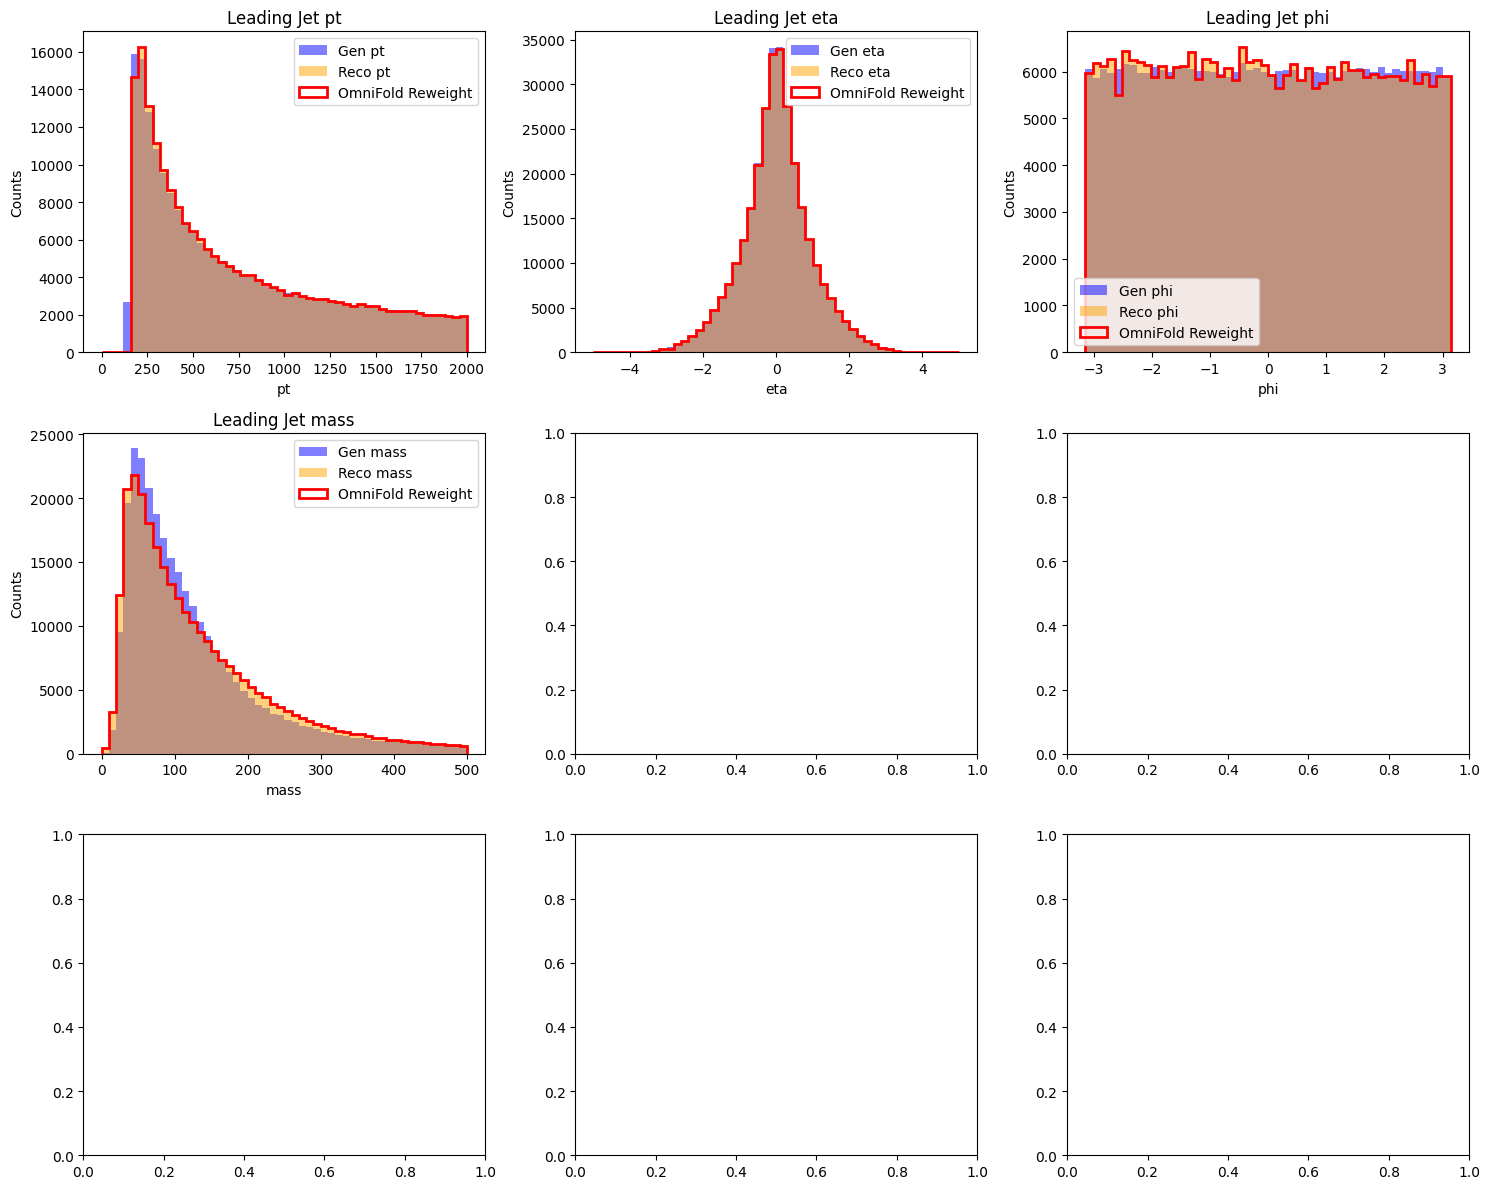

In [4]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Define the weighted binary crossentropy
def weighted_binary_crossentropy(y_true, y_pred):
    weights = y_true[:, 1]
    y_true = y_true[:, 0]
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_mean(loss * weights)

# Define the model architecture and compilation
def build_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.1),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss=weighted_binary_crossentropy, metrics=['accuracy'])
    return model

# Define the OmniFold method (to be replaced with your actual implementation)
def omnifold(theta0, theta_unknown_S, iterations, model, verbose):
    # Your actual OmniFold algorithm should be implemented here
    # For now, this function just returns an array of ones as weights
    return np.ones(len(theta0))  # Make sure to replace this with the actual returned weights

# Load data from ROOT file
qcd_mc = uproot.open('Data2.root')['Events']

# Extract reco and gen jet data
fields = ['pt', 'eta', 'phi', 'mass']
jet_reco = {f: qcd_mc[f'FatJet_{f}'].array()[:, :1] for f in fields}
jet_gen = {f: qcd_mc[f'GenJetAK8_{f}'].array()[:, :1] for f in fields}

# Mask to filter valid events
mask = (ak.num(jet_reco['pt'], axis=1) > 0) & (ak.num(jet_gen['pt'], axis=1) > 0)
for f in fields:
    jet_reco[f] = jet_reco[f][mask]
    jet_gen[f] = jet_gen[f][mask]

# Calculate DeltaR
delta_eta = ak.to_numpy(jet_reco['eta'] - jet_gen['eta'])
delta_phi = ak.to_numpy((jet_reco['phi'] - jet_gen['phi'] + np.pi) % (2 * np.pi) - np.pi)
delta_r = np.sqrt(delta_eta**2 + delta_phi**2)

# Prepare data for OmniFold reweighting
theta0 = np.stack([ak.to_numpy(jet_gen['pt']), ak.to_numpy(jet_gen['eta'])], axis=1)
theta_unknown_S = np.stack([ak.to_numpy(jet_reco['pt']), ak.to_numpy(jet_reco['eta'])], axis=1)

# Initialize and compile the model for OmniFold
input_dim = theta0.shape[1]
model = build_model(input_dim)

# Run OmniFold and obtain the weights
weights = omnifold(theta0, theta_unknown_S, iterations=10, model=model, verbose=1)

# Check if weights were returned correctly
if weights is None:
    raise ValueError("The omnifold function did not return weights")

# Normalize the weights
normalized_weights = weights / np.sum(weights) * len(weights)

# Define bins for histograms
bin_settings = {
    'pt': np.linspace(0, 2000, 51),
    'eta': np.linspace(-5, 5, 51),
    'phi': np.linspace(-np.pi, np.pi, 51),
    'mass': np.linspace(0, 500, 51),
}

# Plotting histograms
fig, axs = plt.subplots(3, 3, figsize=(15, 12))  # Adjust the layout if necessary

for i, prop in enumerate(fields):
    row, col = divmod(i, 3)
    bins = bin_settings[prop]
    gen_data = ak.to_numpy(ak.flatten(jet_gen[prop]))
    reco_data = ak.to_numpy(ak.flatten(jet_reco[prop]))
    
    axs[row, col].hist(gen_data, bins=bins, alpha=0.5, label=f'Gen {prop}', color='blue')
    axs[row, col].hist(reco_data, bins=bins, alpha=0.5, label=f'Reco {prop}', color='orange')
    axs[row, col].hist(reco_data, bins=bins, weights=normalized_weights, histtype='step', label='OmniFold Reweight', color='red', linewidth=2)
    
    axs[row, col].set_title(f'Leading Jet {prop}')
    axs[row, col].set_xlabel(prop)
    axs[row, col].set_ylabel('Counts')
    axs[row, col].legend()

plt.tight_layout()
plt.show()
